using cupy edt
Chamfer Distance 7.026793173281476e-05
SSIM 0.8245111099895021
PSNR 12.935955987616904


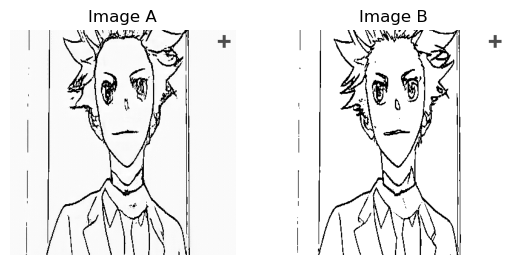

In [6]:
'''
Returns the Chamfer Distance between two images
'''
# import sys
# sys.path.append('../')
from _eval.chamfer_dist import batch_chamfer_distance
from skimage.metrics import structural_similarity as get_ssim
from skimage.metrics import peak_signal_noise_ratio as get_psnr
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt


path_a = '../mini_datasets/cd_visualizer_gifs/small - GAN - light_cropped_marked.gif'
path_b = '../mini_datasets/cd_visualizer_gifs/small_true_marked.gif'
gif = True

if gif:
    frame = Image.open(path_a)
    frame.seek(1)
    img_a = frame.convert('L').copy()
    frame = Image.open(path_b)
    frame.seek(1)
    img_b = frame.convert('L').copy()
else:
    img_a = Image.open(path_a)
    img_b = Image.open(path_b)



# Read batch of images as torch tensors
img_a = torch.tensor(np.array(img_a), dtype=torch.float32)
img_a = img_a / img_a.max()
img_b = torch.tensor(np.array(img_b), dtype=torch.float32)
img_b = img_b / img_b.max()
# create blank image: image with white pixels only (value of 1) with the same shape of image b
# img_a = torch.ones_like(img_b)- 1.0


ssim = get_ssim(img_a.cpu().numpy(), img_b.cpu().numpy(), multichannel=False, data_range=1.0)
psnr = get_psnr(img_a.cpu().numpy(), img_b.cpu().numpy(), data_range=1.0)


# Unsqueeze to add batch dimension if there aren't any (batch_chamfer_distance() expects a batch of images)
if len(img_a.shape) < 3:
    img_a = img_a.unsqueeze(0)
    img_b = img_b.unsqueeze(0)


# Calculate Chamfer Distance
chamfer_distance = batch_chamfer_distance(img_a, img_b, bit_reverse=True)
print('Chamfer Distance', chamfer_distance.item())
print('SSIM', ssim)
print('PSNR', psnr)


# Visualize the images
plt.figure()
plt.subplot(1, 2, 1)  # arguments are nrows, ncols, index
plt.imshow(img_a.squeeze(0), cmap='gray')
plt.title("Image A")
plt.grid(False)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_b.squeeze(0), cmap='gray')
plt.title("Image B")
plt.grid(False)
plt.axis('off')

plt.show()

In [7]:
from PIL import Image, ImageSequence
from torchvision import transforms
import numpy as np

def crop_gif(input_path, shape=(373,373)):
    gif = Image.open(input_path)

    frames = []
    # Define the CenterCrop transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
        transforms.CenterCrop(shape)
    ])

    for frame in ImageSequence.Iterator(gif):
        # Center crop frame to size of shape with torch transforms
        cropped = transform(frame)
        cropped = cropped / cropped.max()
        cropped = transforms.ToPILImage()(cropped)
        frames.append(cropped)
    
    frames[0].save(input_path[:-4] + '_cropped.gif', save_all=True, append_images=frames[1:], 
                duration=500, loop=0)
    
    print('Cropped gif saved at', input_path[:-4] + '_cropped.gif')
        


In [11]:
import sys
sys.path.append('../')
print(sys.path)

from _utils.utils import crop_gif
import os


crop_gif('/home/farriaga/gan-interpolator/mini_datasets/cd_visualizer_gifs/large - UNET - light_cropped.gif')

['/home/farriaga/gan-interpolator/_notebooks', '/home/farriaga/miniconda3/envs/pytorch_env/lib/python311.zip', '/home/farriaga/miniconda3/envs/pytorch_env/lib/python3.11', '/home/farriaga/miniconda3/envs/pytorch_env/lib/python3.11/lib-dynload', '', '/home/farriaga/miniconda3/envs/pytorch_env/lib/python3.11/site-packages', '../', '../', '../', '../', '../', '../']
Cropped gif saved at /home/farriaga/gan-interpolator/mini_datasets/cd_visualizer_gifs/large - UNET - light_cropped_cropped.gif


In [3]:
from _utils.utils import mark_frame_in_gif
import os

# read all gifs in a directory
path = 'mini_datasets/cd_visualizer_gifs'
for gif in os.listdir(path):
    # join path and gif name
    mark_frame_in_gif(os.path.join(path, gif), frame_index=1)

Saved marked GIF to mini_datasets/cd_visualizer_gifs/small - GAN - full_marked.gif
Saved marked GIF to mini_datasets/cd_visualizer_gifs/small - UNET - full_marked.gif
Saved marked GIF to mini_datasets/cd_visualizer_gifs/large - GAN - light_cropped_marked.gif
Saved marked GIF to mini_datasets/cd_visualizer_gifs/large - GAN - full_marked.gif
Saved marked GIF to mini_datasets/cd_visualizer_gifs/large - UNET - light_cropped_marked.gif
Saved marked GIF to mini_datasets/cd_visualizer_gifs/large - UNET - full_marked.gif
Saved marked GIF to mini_datasets/cd_visualizer_gifs/small - UNET - light_cropped_marked.gif
Saved marked GIF to mini_datasets/cd_visualizer_gifs/eyes - GAN - light_cropped_marked.gif
Saved marked GIF to mini_datasets/cd_visualizer_gifs/medium - UNET - full_marked.gif
Saved marked GIF to mini_datasets/cd_visualizer_gifs/medium - GAN - light_cropped_marked.gif
Saved marked GIF to mini_datasets/cd_visualizer_gifs/small - GAN - light_cropped_marked.gif
Saved marked GIF to mini_da

In [2]:
import sys
sys.path.append('../')

from torchsummary import summary

from _generators.generator_crop import UNetCrop
from _generators.generator_light import GeneratorLight
from _generators.generator_light_spectral import GeneratorLightSpectral
from _discriminators.discriminator_crop import DiscriminatorCrop
from _discriminators.discriminator_full import DiscriminatorFull
from _discriminators.discriminator_full_spectral import DiscriminatorFullSpectral
from _discriminators.discriminator_crop_double import DiscriminatorCropDouble

# Counts the number of parameters in a pre-trained network
model = DiscriminatorFull(1, 16).cuda()
summary(model, input_size=[(1, 512, 512)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             256
         LeakyReLU-2         [-1, 16, 256, 256]               0
         Dropout2d-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 32, 128, 128]           8,192
       BatchNorm2d-5         [-1, 32, 128, 128]              64
         LeakyReLU-6         [-1, 32, 128, 128]               0
         Dropout2d-7         [-1, 32, 128, 128]               0
            Conv2d-8           [-1, 64, 64, 64]          32,768
       BatchNorm2d-9           [-1, 64, 64, 64]             128
        LeakyReLU-10           [-1, 64, 64, 64]               0
        Dropout2d-11           [-1, 64, 64, 64]               0
           Conv2d-12          [-1, 128, 32, 32]         131,072
      BatchNorm2d-13          [-1, 128, 32, 32]             256
        LeakyReLU-14          [-1, 128,